# Diffusion Process Step by Step

This notebook breaks down the diffusion process. Steps are shown for text to image and image to image generation.

* **Text to Image:** The Text to Image (TEXT2IMG) diffusion process initiates with a textual prompt that specifies the desired image. The model generates a noise image and employs a series of iterative denoising steps to progressively refine the image described in the prompt.
* **Image to Image:** The Image to Image (IMG2IMG) diffusion process works with a provided input image and a corresponding textual prompt. The diffusion process introduces noise to the initial image and applies iterative denoising to modify the image. 

In [1]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

import torch
from torchvision import transforms as img_transforms

import requests
from io import BytesIO
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import os
import numpy as np
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')

/home/lecturer/miniconda3/envs/pytorch/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/lecturer/miniconda3/envs/pytorch/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


using device: cuda


# Hyperparameters

In [2]:
hyperparameters = {
    'seed': 1234,
    'model_id': 'CompVis/stable-diffusion-v1-4',
    'img_size': (512, 512),
}

# Load Pre-trained
### Variational Autoencoder (VAE)
Downsamples/upsamples the input

In [3]:
vae = AutoencoderKL.from_pretrained(
    hyperparameters['model_id'], 
    subfolder='vae', 
    use_safetensors=True
).eval().to(device)

### VAE Utility Functions

In [4]:
@torch.no_grad()
def pil_to_latent(input_img, vae, img_transforms, device):
    """
    Utility functiion for image to image
    """
    # convert PIl image to tensor of values [0.0, 1.0]
    input_img = img_transforms.ToTensor()(input_img)
    # add dummy batch dimension
    input_img = input_img.unsqueeze(0)
    # scale tensor values between [-1.0, 1.0]
    input_img = input_img*2.0-1.0
    # move to GPU (if available)
    input_img = input_img.to(device)
    # generate lower dimension sample latents by VAE
    latent_sample = vae.encode(input_img).latent_dist.sample()
    # scale the latents (required for latent diffusion to work)
    # scale factor is 0.18215 by default
    latent_sample *= vae.config.scaling_factor
    return latent_sample

@torch.no_grad()
def latents_to_pil(latents, vae):
    """
    Utility functiion for both image to image and text to image
    """
    # unscale the latents (required for VAE decoding to work)
    # scale factor is 0.18215 by default
    latents = (1.0 / vae.config.scaling_factor) * latents
    # decode latents into image with higher dimensions
    image = vae.decode(latents).sample
    # scale tensor values of [-1.0, 1.0] to original [0.0, 1.0]
    image = (image / 2.0 + 0.5).clamp(0, 1)
    # (N, C, H, W) -> (N, H, W, C)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    # convert to pixels by [0.0, 1.0] -> [0, 255] (8-bit unsigned integer) 
    images = (image * 255.0).round().astype('uint8')
    # PIL image list
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

### Text Encoder
Converts text into embedding vectors

In [5]:
tokenizer = CLIPTokenizer.from_pretrained(
    hyperparameters['model_id'],
    subfolder='tokenizer'
)

text_encoder = CLIPTextModel.from_pretrained(
    hyperparameters['model_id'],
    subfolder='text_encoder', 
    use_safetensors=True
).eval().to(device)

/home/lecturer/miniconda3/envs/pytorch/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### U-Net
Latent Diffusion

In [6]:
unet = UNet2DConditionModel.from_pretrained(
    hyperparameters['model_id'],
    subfolder='unet', 
    use_safetensors=True
).eval().to(device)

### Scheduler
Add noise to latents gradually

In [7]:
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule='scaled_linear',
    num_train_timesteps=1000
)

# Download Image (Image to Image Only)

In [8]:
def download_pil_image(img_url, img_size):
    response = requests.get(img_url)
    init_image = Image.open(BytesIO(response.content)).convert('RGB')
    init_image = init_image.resize(img_size)
    return init_image

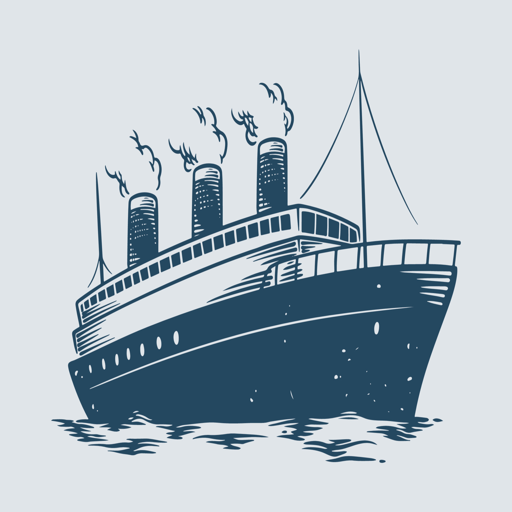

In [9]:
#URL = 'https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg'
#URL = 'https://carwow-uk-wp-3.imgix.net/18015-MC20BluInfinito-scaled-e1707920217641.jpg'
#URL = 'https://www.astronomy.com/uploads/2023/03/spacesound.png'
#URL = 'https://img.freepik.com/premium-photo/glowing-spaceship-orbits-planet-starry-galaxy-generated-by-ai_1038396-45.jpg'
#URL = 'https://www.shutterstock.com/image-illustration/one-old-steam-boat-on-260nw-2120625971.jpg'
#URL = 'https://images.squarespace-cdn.com/content/v1/5c48db894eddeca43abfade1/1553889232727-XQJYFDI5ECZFFQYNC8S0/puffin1.jpg'
#URL = 'https://transportationhistory.org/wp-content/uploads/2021/04/ss_great_western_1882_engraving.jpg?w=1400'
URL = 'https://static.vecteezy.com/system/resources/previews/018/715/440/original/hand-drawing-vintage-steam-boat-trans-atlantic-ocean-theme-vector.jpg'

init_image = download_pil_image(URL, hyperparameters['img_size'])

init_image

In [10]:
img_latents = pil_to_latent(init_image, vae, img_transforms, device)
img_latents.shape

torch.Size([1, 4, 64, 64])

# Text Encoding

In [11]:
@torch.no_grad()
def encode_text(prompt, tokenizer, use_guidence, batch_size, device):
    text_input = tokenizer(
        prompt, 
        padding='max_length', 
        max_length=tokenizer.model_max_length, 
        truncation=True, 
        return_tensors='pt'
    )

    input_ids = text_input.input_ids.to(device)
    text_embeddings = text_encoder(input_ids)[0] # TODO: batch support

    if use_guidence:
        uncond_input = tokenizer(
            ['']*batch_size, 
            padding='max_length', 
            max_length=tokenizer.model_max_length, 
            return_tensors='pt'
        )
        
        uncond_input = uncond_input.input_ids.to(device)
        uncond_embeddings = text_encoder(uncond_input)[0] # TODO: batch support
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    return text_embeddings

# Generation Parameters

In [12]:
PROMPT = 'A bustling cyberpunk metropolis at night, filled with neon lights, flying cars, and towering skyscrapers, in a vibrant and dynamic composition'
#PROMPT = 'A detailed steampunk airship, Victorian design'

# If True, image encodings from VAE is used as an initial noisy latent (IMG2IMG)
# If False, random noise is used as initial noisy latent (TEXT2IMG)
IMG2IMG = True

NUM_INFERENCE_STEPS = 50
START_STEP = 14

USE_GUIDENCE = True
GUIDENCE_SCALE = 8.0

### Encode Text with CLIP

In [13]:
text_embeddings = encode_text(
    prompt=PROMPT, 
    tokenizer=tokenizer,
    use_guidence=USE_GUIDENCE,
    batch_size=1,
    device=device
)

text_embeddings.shape

torch.Size([2, 77, 768])

# Scheduler Setup

img_latents.mean().item()=0.350866   img_latents.std().item()=0.9430
latents.mean().item()=0.3495   latents.std().item()=3.6702
torch.Size([1, 4, 64, 64])


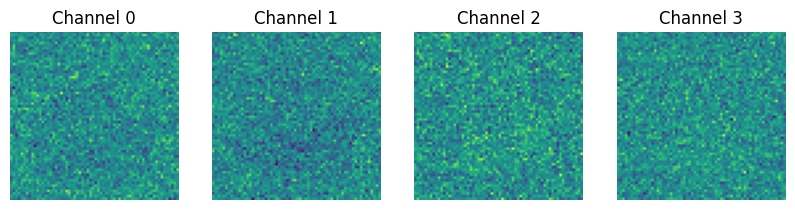

In [14]:
scheduler.set_timesteps(NUM_INFERENCE_STEPS)
scheduler.timesteps = scheduler.timesteps.to(torch.float32)

noise = torch.randn(*img_latents.shape, generator=torch.manual_seed(hyperparameters['seed'])).to(device)

print(f'{img_latents.mean().item()=:4f}   {img_latents.std().item()=:.4f}')

latents = scheduler.add_noise(
    img_latents if IMG2IMG else noise, 
    noise, 
    timesteps=torch.tensor([scheduler.timesteps[START_STEP]])
)

print(f'{latents.mean().item()=:.4f}   {latents.std().item()=:.4f}')
print(latents.shape)

latents_numpy = latents.cpu().numpy()

# each channel dim is a different subplot
fig, ax = plt.subplots(nrows=1, ncols=latents_numpy.shape[1], figsize=(10, 5))

for channel_id in range(latents_numpy.shape[1]):
    ax[channel_id].imshow(latents_numpy[0, channel_id, :, :])
    ax[channel_id].axis('off')
    ax[channel_id].set_title(f'Channel {channel_id}')

### Move latents to GPU

In [15]:
latents = latents.to(device)

# Diffusion Loop

In [16]:
@torch.no_grad()
def perform_diffusion(latents, unet, text_embeddings, scheduler, use_guidence, guidance_scale, start_step):
    for timestep_idx in tqdm(range(start_step, len(scheduler.timesteps)), initial=start_step, total=len(scheduler.timesteps)):

        # get the current timestamp
        t = scheduler.timesteps[timestep_idx]
                
        if use_guidence:
            latent_model_input = torch.cat([latents] * 2)
        else:
            latent_model_input = latents
        
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

        if use_guidence:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    return latents

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  5.82it/s]


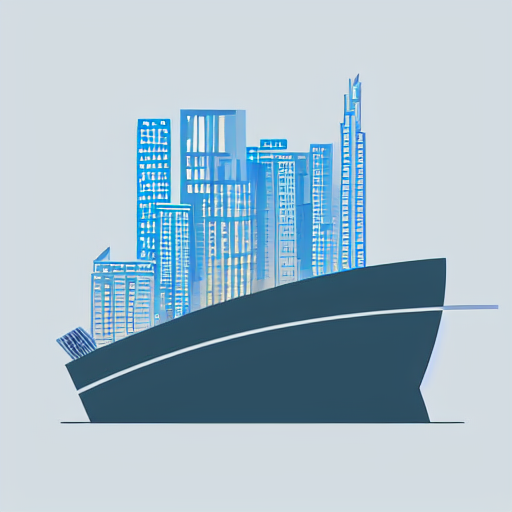

In [17]:
diffused_latents = perform_diffusion(latents, unet, text_embeddings, scheduler, use_guidence=USE_GUIDENCE, guidance_scale=GUIDENCE_SCALE, start_step=START_STEP)

latents_to_pil(diffused_latents, vae)[0]